# Исследование стартапов

- Автор: Елагина Ксения

## Введение

### Цели и задачи проекта
Необходимо провести исследовательский анализ стартапов с целью разработки модели бизнеса для финансовой компании.

Задачи:
- Загрузить данные и познакомиться с ними.
- Предобработать данные и подготовить их к исследованию:
  - Провести преобразование типов данных, если необходимо.
  - Проверить данные на пропуски.
  - Проверить данные на явные и неявные дубликаты.
  - Изучить динамику типичного размера средств, которые стартапы получали в рамках одного раунда финансирования.
  - Определить, зависит ли полнота сведений о сотрудниках от размера компаний.
  - Установить возможность объединения датафреймов по столбцу `network_username`.
  - Привести данные таблицы `company_and_rounds` в вид, который позволит в дальнейшем проводить анализ в разрезе отдельных компаний.
- Провести исследовательский анализ:
  - Объединить датасеты для дальнейшего анализа.
  - Проанализировать размеры общего финансирования для разных компаний.
  - Исследовать компании, которые были проданы за ноль или за один доллар и у которых был ненулевой общий объём финансирования.
  - Изучить цены стартапов по категориям.
  - Изучить типичное значение количества раундов по статусам стартапов.
- Сделать выводы и рекомендации.

## Знакомство с данными: загрузка и первичная предобработка

### Вывод общей информации

In [1]:
!pip install phik==0.12.3

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

In [3]:
# Выгружаем данные
base_url = '/'

company_and_rounds = pd.read_csv(base_url + 'company_and_rounds.csv')
acquisition = pd.read_csv(base_url + 'acquisition.csv')
people = pd.read_csv(base_url + 'people.csv')
education = pd.read_csv(base_url + 'education.csv')
degrees = pd.read_csv(base_url + 'degrees.csv')

**1. Проанализируем датафрейм company_and_rounds.**

In [4]:
# Выведем информацию о датафрейме:
company_and_rounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company  ID            217472 non-null  float64
 1   name                   217471 non-null  object 
 2   category  code         143886 non-null  object 
 3   status                 217472 non-null  object 
 4   founded  at            109956 non-null  object 
 5   closed  at             3449 non-null    object 
 6   domain                 147159 non-null  object 
 7   network  username      95534 non-null   object 
 8   country  code          108607 non-null  object 
 9   investment  rounds     217472 non-null  float64
 10  funding  rounds        217472 non-null  float64
 11  funding  total         217472 non-null  float64
 12  milestones             217472 non-null  float64
 13  funding  round  id     52928 non-null   float64
 14  company  id            52928 non-nul

Выведем количество и процент пропущенных значений.

In [5]:
(pd.DataFrame({'Кол-во пропусков': company_and_rounds.isna().sum(), 'Доля пропусков': company_and_rounds.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
closed at,214325,98.416248
funded at,165094,75.809784
is last round,164846,75.695905
funding round type,164846,75.695905
is first round,164846,75.695905
participants,164846,75.695905
pre money valuation,164846,75.695905
raised amount,164846,75.695905
funding round id,164846,75.695905
company id,164846,75.695905


Датасет `company_and_rounds` содержит 22 столбца и 217774 строк, в которых представлена информация о компаниях и раундах финансирования.

После первичного анализа данных можно сделать следующие выводы:
- в датафрейме встречается по 2 столбца с идентификатором компании (`company  ID`, `company  id`). Необходимо переименовать одинаковые `company id`, чтобы не запутаться при дальнейшем анализе. Также не совсем понятна причина возникновения одинаковых столбцов, в которых совпадают не все данные.
- необходимо привести названия столбцов к стилю snake_case и проверить их на соответствие значению имени.
- во всех столбцах есть пропуски. Большее количество пропусков содержится в столбце "дата закрытия компании" (98%), т.к. большая часть компаний все еще работают.
- столбцы `investment rounds`, `participants` и `funding rounds` содержат информацию о количестве, соответственно их нужно привести из float64 к типу int.
- company ID, funding round id, company id следует привести тоже из float64 к типу int, т.к. id не может иметь дробную часть.
- `founded at`, `closed at`, `funded at` из типа object необходимо привести к типу datetime, т.к. данные столбцы содержат в себе даты.
- `is first round`, `is last round` находятся в типе float64, в них содержится булевая информация в числах, приведем к типу int.

In [6]:
# Выведем названия всех столбцов:
company_and_rounds.columns

Index(['company  ID', 'name', 'category  code', 'status', 'founded  at',
       'closed  at', 'domain', 'network  username', 'country  code',
       'investment  rounds', 'funding  rounds', 'funding  total', 'milestones',
       'funding  round  id', 'company  id', 'funded  at',
       'funding  round  type', 'raised  amount', 'pre  money  valuation',
       'participants', 'is  first  round', 'is  last  round'],
      dtype='object')

Приведем названия столбцов к snake_case.

In [7]:
# Переименуем отдельные названия столбцов, чтобы они соответствовали своим значениям, а также company id:
company_and_rounds = company_and_rounds.rename(
    columns = {'company  ID':'company_id_source_1',
               'company  id':'company_id_source_2'})

# Приведем названия столбцов к snake_case:
company_and_rounds.columns = (
    company_and_rounds.columns
    .str.strip()
    .str.lower()
    .str.replace('  ', '_'))

# Выведем названия столбцов:
company_and_rounds.columns

Index(['company_id_source_1', 'name', 'category_code', 'status', 'founded_at',
       'closed_at', 'domain', 'network_username', 'country_code',
       'investment_rounds', 'funding_rounds', 'funding_total', 'milestones',
       'funding_round_id', 'company_id_source_2', 'funded_at',
       'funding_round_type', 'raised_amount', 'pre_money_valuation',
       'participants', 'is_first_round', 'is_last_round'],
      dtype='object')

**2. Проанализируем датафрейм acquisition.**

In [8]:
# Выведем информацию о датафрейме:
acquisition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    9407 non-null   int64 
 1   acquiring_company_id  9407 non-null   int64 
 2   acquired_company_id   9407 non-null   int64 
 3   term_code             1831 non-null   object
 4   price_amount          9407 non-null   int64 
 5   acquired_at           9378 non-null   object
dtypes: int64(4), object(2)
memory usage: 441.1+ KB


Выведем количество и процент пропущенных значений.

In [9]:
(pd.DataFrame({'Кол-во пропусков': acquisition.isna().sum(), 'Доля пропусков': acquisition.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
term_code,7576,80.535771
acquired_at,29,0.308281
id,0,0.000000
acquiring_company_id,0,0.000000
acquired_company_id,0,0.000000
price_amount,0,0.000000


Датасет `acquisition` содержит 6 столбцов и 9407 строк, в которых представлена информация о покупках одними компаниями других компаний.

После первичного анализа данных можно сделать следующие выводы:
- необходимо проверить столбцы на соответствие их значению.
- пропуски содержатся в столбцах `term_code` и `acquired_at`, что означает о неполноте информации:
  - в `term_code` их более 80%
  - в `acquired_at` менее 1%, поэтому их можно будет удалить для дальнейшего анализа.
- столбец `acquired_at` содержит информацию о дате, соответственно необходимо тип object привести к datetime.

In [10]:
# Переименуем столбец для соответствия своему значению:
acquisition = acquisition.rename(columns = {'term_code':'payment_type'})

**3. Проанализируем датафрейм people.**

In [11]:
# Выведем информацию о датафрейме:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                226709 non-null  int64  
 1   first_name        226700 non-null  object 
 2   last_name         226705 non-null  object 
 3   company_id        34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB


Выведем количество и процент пропущенных значений.

In [12]:
(pd.DataFrame({'Кол-во пропусков': people.isna().sum(), 'Доля пропусков': people.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
company_id,192094,84.731528
network_username,187842,82.855996
first_name,9,0.003970
last_name,4,0.001764
id,0,0.000000


Датасет `people` содержит 5 столбцов и 226709 строк, в которых представлена информация о сотрудниках.

После первичного анализа данных можно сделать следующие выводы:
- все столбцы, кроме `id` содержат пропуски:
  - большее количество пропусков в company_id - 85% и network_username - 83%. 
  - в `first_name` и `last_name` пропусков меньше 1%. Возможно, это связано с отсутствием данных об этих сотрудниках или ошибкой при переносе данных. Т.к. пропусков не так мало, то их можно удалить.
- `company_id` нужно привести к типу int: id не могут иметь дробную часть.

**4. Проанализируем датафрейм education.**

In [13]:
# Выведем информацию о датафрейме:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            109610 non-null  int64 
 1   person_id     109610 non-null  int64 
 2   instituition  109555 non-null  object
 3   graduated_at  58054 non-null   object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


Выведем количество и процент пропущенных значений.

In [14]:
(pd.DataFrame({'Кол-во пропусков': education.isna().sum(), 'Доля пропусков': education.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
graduated_at,51556,47.035854
instituition,55,0.050178
id,0,0.000000
person_id,0,0.000000


Датасет `education` содержит 4 столбца и 109610 строк, в которых представлена информация об образовании сотрудника.

После первичного анализа данных можно сделать следующие выводы:
- столбец `instituition` содержит пропуски, вероятно, некоторые сотрудники не заканчивали учебное заведение, либо нет никакой информации об этом.
- в столбце `graduated_at` 47% пропусков, что указывает на то, что половина сотрудников еще учатся и не закончили обучение.
- в столбце `instituition` менее 1% пропусков, соответственно, можно удалить данные строки.
- столбец `graduated_at` содержит дату, необходимо привести его к типу datetime.

**5. Проанализируем датафрейм degrees.**

In [15]:
# Выведем информацию о датафрейме:
degrees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           109610 non-null  int64 
 1   object_id    109610 non-null  object
 2   degree_type  98389 non-null   object
 3   subject      81298 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


Выведем количество и процент пропущенных значений.

In [16]:
(pd.DataFrame({'Кол-во пропусков': degrees.isna().sum(), 'Доля пропусков': degrees.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
subject,28312,25.829760
degree_type,11221,10.237205
id,0,0.000000
object_id,0,0.000000


Датасет `degrees` содержит 4 столбца и 109610 строк, в которых представлена информация о типе образования сотрудника.

После первичного анализа данных можно сделать следующие выводы:
- пропуски находятся в столбцах `degree_type` - 26% и subject - 10%. Часть сотрудников могут не иметь образования, поэтому столбец содержит NaN, а пропуски в специальности могли появиться из-за отсутствия информации.
- столбец `object_id` записан в виде типа object, из-за чего данный датафрейм невозможно присоединить к другим. Необходимо изменить тип на целочисленный и перед этим убрать перед числами значение 'p:'. 

### 1.2. Смена типов и анализ пропусков

Обработаем типы данных в столбцах, которые хранят значения даты и времени.

In [17]:
# Создадим функцию для приведения столбцов датафреймов к типу данных datetime:
def convert_to_datetime(df, col_name):
    '''
    Функция приводит указанный столбец датафрейма к типу datetime.

    '''
    df[col_name] = pd.to_datetime(df[col_name], errors='coerce')
    return df

In [18]:
# Обработаем типы данных в столбцах, которые хранят значения даты и времени:
company_and_rounds = convert_to_datetime(company_and_rounds, 'founded_at')
company_and_rounds = convert_to_datetime(company_and_rounds, 'funded_at')
company_and_rounds = convert_to_datetime(company_and_rounds, 'closed_at')
education = convert_to_datetime(education, 'graduated_at')
acquisition = convert_to_datetime(acquisition, 'acquired_at')

In [19]:
# Проверим правильность преобразования:
print(company_and_rounds[['founded_at', 'funded_at', 'closed_at']].dtypes)
print(education[['graduated_at']].dtypes)
print(acquisition[['acquired_at']].dtypes)

founded_at    datetime64[ns]
funded_at     datetime64[ns]
closed_at     datetime64[ns]
dtype: object
graduated_at    datetime64[ns]
dtype: object
acquired_at    datetime64[ns]
dtype: object


In [20]:
# Проверим датафреймы на наличие явных дубликатов:
print(acquisition.duplicated().sum())
print(company_and_rounds.duplicated().sum())
print(education.duplicated().sum())
print(people.duplicated().sum())
print(degrees.duplicated().sum())

0
0
0
0
0


Ни в одном из датафреймов явных дубликатов не присутствует.

In [21]:
# Проверим столбцы на наличие неявных дубликатов:
print(acquisition['payment_type'].unique())


[nan 'cash' 'stock' 'cash_and_stock']


In [22]:
# Выведем количество неявных дубликатов столбца name:
company_and_rounds['name'].fillna('').astype(str).str.lower().nunique()

196505

In [23]:
# Выведем количество неявных дубликатов столбца country_code:
company_and_rounds['country_code'].fillna('').nunique()

176

В датафрейме `company_and_rounds` отсутствует огромное количество данных. В большей половине столбцов отсутствует более 30% информации. В 9 столбцах отсутствует по 75% данных. А данную таблицу можно считать самой основной. 

В таблице `people` в столбце `company_id` отсутствует 85% данных, которые передают информацию об идентификаторе компании. В `acquisition` в столбце с вариантом расчета тоже нет 80% информации. В таблице `education` есть столбец с 47% пропусков.

Поэтому будет сложно провести достоверный анализ при таком количестве пропусков. 

---

### Промежуточный вывод


В результате предобработки данных были выполнены следующие действия:
- Датасет **company_and_rounds**:
    - названия столбцов привели к стилю snake_case и проверили их на соответствие значению имени.
    - изучили пропуски данных. Они есть во всех столбцах. Большее количество содержится в столбце "дата закрытия компании" (98%), т.к. большая часть компаний все еще работают.
    - был сделан вывод, что столбцы investment rounds, participants, funding rounds, company ID, funding round id, company id, is first round, is last round необходимо привести к типу int.
    - названия столбцов привели к виду snake_case.

- Датасет **acquisition**:
    - изучили пропуски: в term_code их более 80%, в acquired_at менее 1%, поэтому был сделан вывод, что их можно удалить.
    - переименовали столбец term_code в более подходящий payment_type.

- Датасет **people**:
    - изучение пропусков выявило, что большее количество находятся в company_id - 85% и network_username - 83%.
    - в first_name и last_name пропусков меньше 1%, поэтому их можно удалить.
    - company_id нужно привести к типу int.

- Датасет **education**:
    - при исследовании было обнаружено, что в столбце graduated_at 47% пропусков.
    - в столбце instituition менее 1% пропусков, соответственно, можно удалить данные строки.

- Датасет **degrees**:
    - исследование пропусков выявило их в столбцах degree_type - 26% и subject - 10%.
    - тип данных столбца object_id необходимо изменить на целочисленный и убрать перед числами значение 'p:'. 

Столбцы `founded at`, `closed at`, `funded at`, `acquired_at`, `graduated_at` привели к типу datetime.

Ни в одном из датафреймов нет дубликатов.

## Предобработка данных, предварительное исследование


### Раунды финансирования по годам

На основе датасета `company_and_rounds` составим сводную таблицу по годам, в которой по столбцу `raised_amount` для каждого года укажем:
- типичный размер средств, выделяемый в рамках одного раунда;
- общее количество раундов финансирования за этот год.

In [24]:
# Извлечем год из столбца даты инвестирования:
company_and_rounds['year'] = company_and_rounds['funded_at'].dt.year.astype('Int64')

In [25]:
# Составим сводную таблицу по годам:
year_pivot = company_and_rounds.pivot_table(index='year',
                                            aggfunc={'raised_amount':'median', 
                                                     'funding_rounds':'count'})
filterd_year_pivot = year_pivot[year_pivot['funding_rounds']>50]
filterd_year_pivot

,funding_rounds,raised_amount
year,,
1999,76,2000000.0
2000,125,4200000.0
2001,95,3000000.0
2002,115,4200000.0
2003,154,3000000.0
2004,286,5000000.0
2005,1624,5500000.0
2006,2409,5000000.0
2007,3220,3973320.0


Построим график, который будет отражать динамику типичного размера средств, которые стартапы получали в рамках одного раунда финансирования.

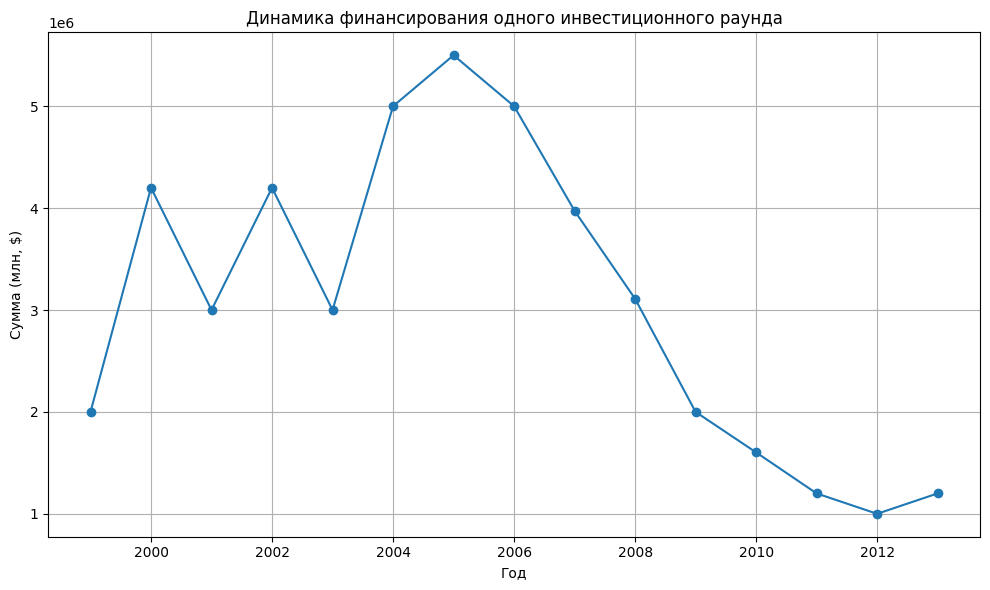

In [26]:
# Построим график:
filterd_year_pivot['raised_amount'].plot(kind='line',
                                         figsize=(10,6),
                                         marker='o')
plt.grid(True)
plt.title('Динамика финансирования одного инвестиционного раунда')
plt.xlabel('Год')
plt.ylabel('Сумма (млн, $)')
plt.tight_layout()
plt.show()

In [27]:
# Отсортируем сводную таблицу по убыванию суммы средств:
filterd_year_pivot.sort_values(by='raised_amount', ascending=False)

,funding_rounds,raised_amount
year,,
2005,1624,5500000.0
2004,286,5000000.0
2006,2409,5000000.0
2000,125,4200000.0
2002,115,4200000.0
2007,3220,3973320.0
2008,3735,3110000.0
2001,95,3000000.0
2003,154,3000000.0


В 2005 году был максимальный сбор денег за 1 раунд стартапа.

В 2013 году отмечается самое высокое количество раундов финансирования, а также с каждым годом динамика по количеству раундов растет. Получается, что с каждым годом стартапов становится больше, и инвесторы активнее вкладываются в новые проекты.


### Люди и их образование

Необходимо оценить, насколько информация об образовании сотрудников полна. Для этого используя датасеты `people.csv` и `education.csv`, разделим все компании на несколько групп по количеству сотрудников и оценим среднюю долю сотрудников без информации об образовании в каждой из групп.

In [28]:
# Объединим таблицы people и education:
employee = people.merge(education, 
                        how='left', 
                        left_on='id', 
                        right_on='person_id')

In [29]:
# Выведем количество и процент пропущенных значений:
(pd.DataFrame({'Кол-во пропусков': employee.isna().sum(), 'Доля пропусков': employee.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
company_id,222905,83.268583
network_username,216919,81.032447
graduated_at,210003,78.448901
instituition,158692,59.281119
id_y,158638,59.260947
person_id,158638,59.260947
first_name,9,0.003362
last_name,4,0.001494
id_x,0,0.000000


В объединенном датасете у большинства столбцов более 59% пропусков, что сильно исказит анализ, касающийся информации о сотрудниках компаний. Тем более пропуски присутствуют в важных столбцах, таких как: id компании и название учебного заведения.

In [30]:
# Посчитаем количество сотрудников в каждой компании:
employee_num = employee.groupby(['company_id'])['person_id'].nunique()

# Выведем статистику по количеству сотрудников:
employee_num.describe(percentiles=[0.01, 0.25, 0.75, 0.99])

count    22922.000000
mean         0.805514
std          2.005217
min          0.000000
1%           0.000000
25%          0.000000
50%          1.000000
75%          1.000000
99%          5.000000
max        168.000000
Name: person_id, dtype: float64

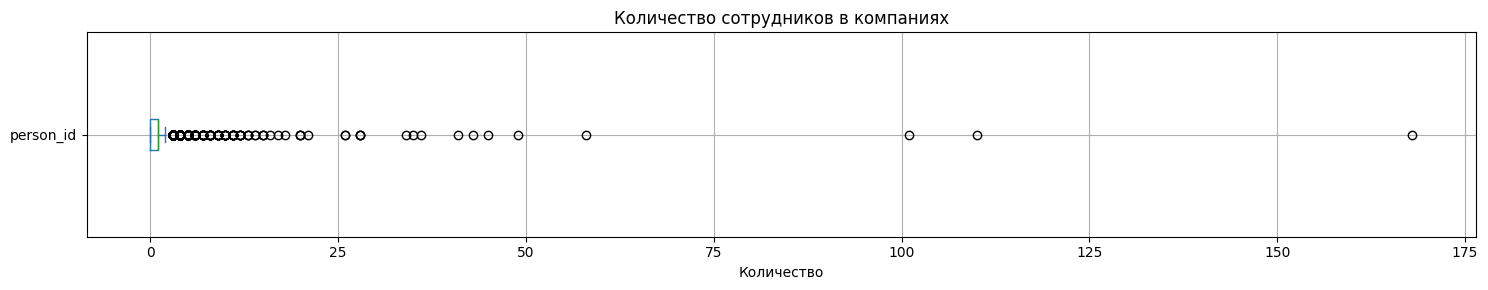

In [31]:
# Построим диаграмму размаха:
employee_num.plot(kind='box',
                  vert=False,
                  figsize=(15,3))
plt.grid(True)
plt.title('Количество сотрудников в компаниях')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

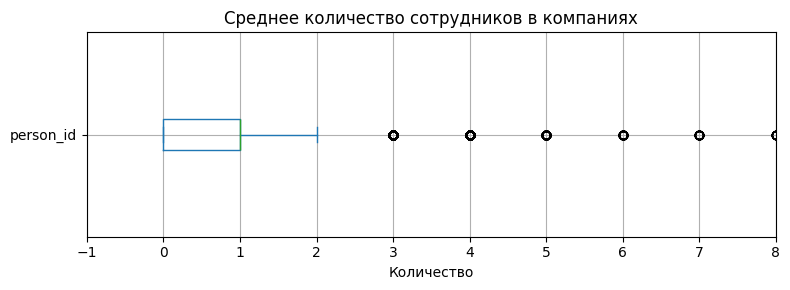

In [32]:
# Построим диаграмму размаха с основными выбросами:
employee_num.plot(kind='box',
                  vert=False,
                  figsize=(8,3))
plt.grid(True)
plt.title('Среднее количество сотрудников в компаниях')
plt.xlabel('Количество')
plt.xlim(-1, 8)
plt.tight_layout()
plt.show()

В датасете присутствуют выбросы, об этом можно судить по диаграмме размаха. Максимальное значение количества сотрудников - 168 человек, хотя 99 процентиль составляет только 5. Получается, что в датасете большинство компаний маленькие - медиана и среднее значение показывают, что большинство компаний состоят только из 1 сотрудника. Также есть нереальные значения - в каких-то компаниях нет сотрудников, чего и вовсе не может быть.

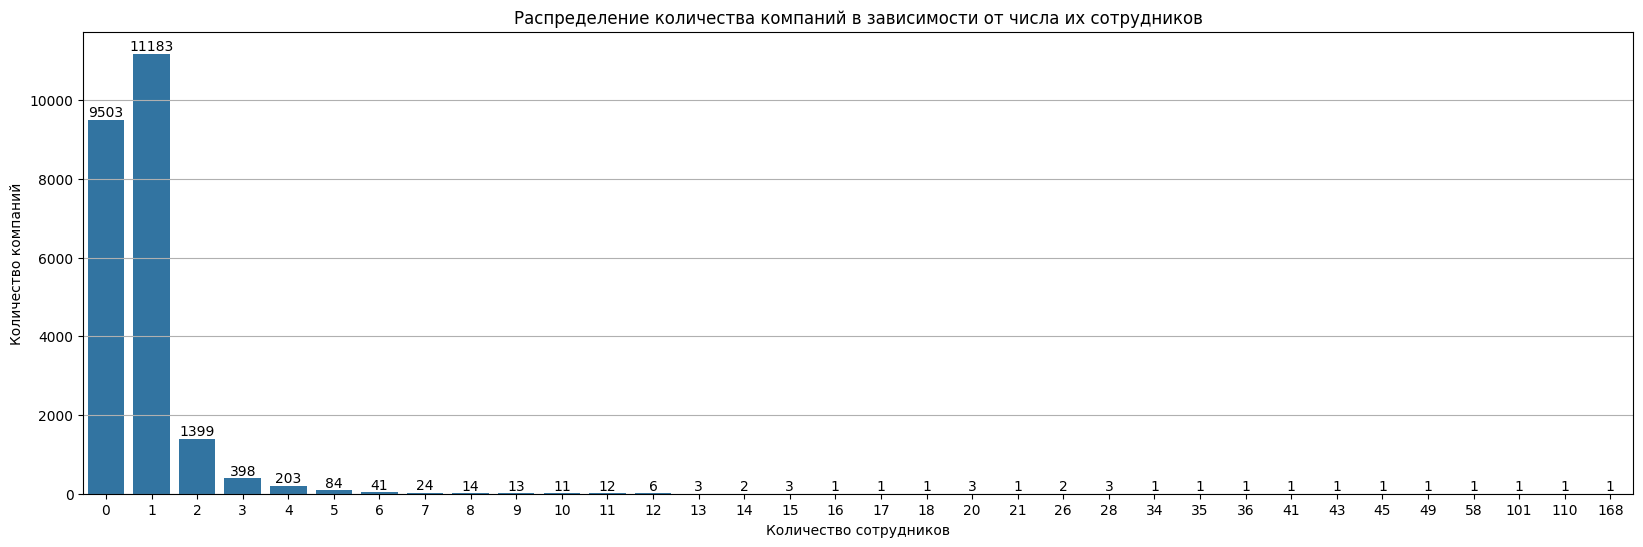

In [33]:
# Построим график, показывающий, сколько компаний имеют определённое количество сотрудников:
plt.figure(figsize=(20,6))
employee_num_ax = sns.countplot(x=employee_num)
plt.grid(True, axis='y')
plt.title('Распределение количества компаний в зависимости от числа их сотрудников')
plt.xlabel('Количество сотрудников')
plt.ylabel('Количество компаний')
employee_num_ax.bar_label(employee_num_ax.containers[0])
plt.show()

Большинство компаний не имеют сотрудников, что неправдоподобно, соответственно, 9503 записи имеют аномальные значения. В датафрейме в основном находятся маленькие компании, в которых находится 1 сотрудник. Вероятно, это стартапы.

Выделим следующие группы: 1, 2, 3, 4, 5-10, 11-24 и более 25. Они содержат схожую градацию.

In [34]:
# Разделим компании на группы по количеству сотрудников:
grouped_company = pd.cut(employee_num, bins=[0, 1, 2, 3, 4, 10, 24, float('inf')], labels=['1', '2', '3', '4', '5-10', '11-24', 'более 25']).copy()
grouped_company.head()

company_id
1.0           1
2.0           1
3.0           2
4.0       11-24
5.0    более 25
Name: person_id, dtype: category
Categories (7, object): ['1' < '2' < '3' < '4' < '5-10' < '11-24' < 'более 25']

In [35]:
# Добавим новый столбец к датафрейму с информацией о сотрудниках:
employee['company_group'] = grouped_company

In [36]:
# Выведем процент среднего количества сотрудников без информации об образовании в каждой из групп:
(employee.groupby('company_group')['instituition']
          .apply(lambda x: x.isna().mean() * 100)
          .round(2)
          .reset_index(name='percent_missing')
          .style.background_gradient(cmap='coolwarm'))

C:\Users\khari\AppData\Local\Temp\ipykernel_14896\3506797709.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (employee.groupby('company_group')['instituition']


,company_group,percent_missing
0,1,62.490000
1,2,64.300000
2,3,62.090000
3,4,67.330000
4,5-10,64.170000
5,11-24,59.380000
6,более 25,56.250000


Во всех компаниях вне зависимости от количества сотрудников отсутствует более 50%, чаще более 60% информации об образовании работников. Следовательно, полнота сведений об образовании сотрудников никак не зависит от размера компаний.

Также к датафрейму `employee` можно присоединить таблицу `degrees`. Но при первичном анализе было замечено, что `object_id` записан в неправильном виде. Выделим из столбца только номера id и переведем в целочисленный вид для присоединения таблицы.

In [37]:
# Преобразуем столбец к правильному виду:
degrees['object_id'] = degrees['object_id'].str.split(':').str[1].astype(int)

In [38]:
# Присоединим таблицу degrees к employee
employee.merge(degrees, how='left', left_on='id_x', right_on='object_id')

,id_x,first_name,last_name,company_id,network_username,id_y,person_id,instituition,graduated_at,company_group,id,object_id,degree_type,subject
0,10,Mark,Zuckerberg,5.0,NaN,2415.0,10.0,Harvard University,NaT,NaN,2415.0,10.0,NaN,Computer Science
1,100,Peter,Lester,27.0,NaN,NaN,NaN,NaN,NaT,1,NaN,NaN,NaN,NaN
2,1000,Dr. Steven,E. Saunders,292.0,NaN,NaN,NaN,NaN,NaT,1,NaN,NaN,NaN,NaN
3,10000,Neil,Capel,2526.0,NaN,NaN,NaN,NaN,NaT,2,NaN,NaN,NaN,NaN
4,100000,Sue,Pilsch,NaN,NaN,NaN,NaN,NaN,NaT,11-24,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370831,99999,Ramon,Peypoch,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
370832,174088,Dr. Ray,Woods,188200.0,network,25958.0,174088.0,Sydney University Medical School,1982-01-01,NaN,25958.0,174088.0,M.B.B.S.,Medicine
370833,118386,Ricardo,Durand,143419.0,itechsocialnet,18871.0,118386.0,ESCS,2004-01-01,NaN,18871.0,118386.0,PhD,Journalism
370834,175827,mahesh,kumar,NaN,socialnethubs,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


Можно отметить, что до этого в датафрейме employee было 267694 строк, теперь же их стало больше - 370836 шт. Поэтому можно предположить, что в таблице degrees встречаются дубликаты идентификаторов сотрудников.

In [39]:
# Проверим количество дубликатов в id:
degrees['object_id'].duplicated().sum()

41159

Гипотеза подтвердилась: присоединение данного датафрейма к employee исказит данные из-за наличия дубликатов. Соответственно, присоединение не целесообразно.

### 2.3. Объединять или не объединять — вот в чём вопрос

Некоторые названия столбцов встречаются в датасетах чаще других. В результате предварительной проверки датасетов было выяснено, что столбец `company_id` подходит для объединения данных.

Необходимо установить, подходит ли для объединения данных столбец `network_username`, который встречается в нескольких датасетах.

In [40]:
# Найдем количество дубликатов в датафрейме company_and_rounds:
company_network_dupl_num = company_and_rounds['network_username'].duplicated().sum()
company_network_dupl_num

138202

In [41]:
# Найдем количество уникальных значений в датафрейме company_and_rounds:
company_network_nunique = company_and_rounds['network_username'].nunique()
company_network_nunique

79571

In [42]:
# Вычислим разницу в значениях:
company_network_dupl_num - company_network_nunique

58631

In [43]:
# Найдем количество дубликатов в датафрейме people:
people_network_dupl_num = people['network_username'].duplicated().sum()
people_network_dupl_num

188287

In [44]:
# Найдем количество уникальных значений в датафрейме people:
people_network_nunique = people['network_username'].nunique()
people_network_nunique

38421

In [45]:
# Вычислим разницу в значениях:
people_network_dupl_num - people_network_nunique

149866

В обоих датафреймах в столбцах `network_username` встречается очень много дубликатов - больше, чем уникальных значений. В датафрейме `company_and_rounds` разница между количеством дубликатов и количеством уникальных значений составила 58631 шт., в таблице `people` - 149866 шт. Поэтому при объединении этих таблиц получится датафрейм с большИм количеством повторов. Следовательно, эти датасеты можно объединить только с учетом дубликатов (убрать их из обеих таблиц), но тогда потеряется большое количество важной информации.


### 2.4. Проблемный датасет и причина возникновения пропусков

В датасете `company_and_rounds` много пропусков в столбце о раундах, который необходим для анализа.

Необходимо привести данные в вид, который позволит в дальнейшем проводить анализ в разрезе отдельных компаний.

Датасет company_and_rounds содержит 2 столбца с идентификатором компаний. Вероятно кто-то объединил 2 таблицы, содержащих информацию о компаниях и о раундах финансирования.

In [46]:
# Сравним значения двух столбцов с id компаний:
company_and_rounds[['company_id_source_1', 'company_id_source_2']].head(10)

,company_id_source_1,company_id_source_2
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,10.0,NaN
4,100.0,NaN
5,10000.0,NaN
6,10001.0,NaN
7,10002.0,NaN
8,10003.0,NaN
9,100042.0,NaN


Можно сделать вывод, что из-за неправильного объединения столбцы задублировались и в итоге в общем датафрейме появилось множество пропущенных значений, а также дубликатов.

Разделим датафрейм на 2 таблицы: по компаниям и раундам инвестирования.

In [47]:
# Создадим таблицу с информацией о компаниях:
company_df = company_and_rounds[['company_id_source_1', 'name', 'category_code', 'status', 
                                 'founded_at', 'closed_at', 'domain', 'network_username', 
                                 'country_code', 'investment_rounds', 'funding_rounds',
                                 'funding_total', 'pre_money_valuation', 'participants']]

In [48]:
# Найдем количество явных дубликатов:
company_df.duplicated().sum()

10168

In [49]:
# Удалим явные дубликаты:
company_df_without_duplicates = company_df.drop_duplicates()

In [50]:
# Найдем количество повторяющихся id компаний: 
company_df_without_duplicates['company_id_source_1'].duplicated().sum()

11052

In [51]:
# Удалим строки с повторяющимися id, оставим только последние:
company_df_without_duplicates = company_df_without_duplicates.drop_duplicates(subset='company_id_source_1', keep='last')
company_df_without_duplicates['company_id_source_1'].duplicated().sum()

# Удалим строки с пропущенными значениями в id:
company_df_without_duplicates = company_df_without_duplicates[company_df_without_duplicates['company_id_source_1'].notna()]

In [52]:
# Создадим таблицу с информацией об инвестиционных раундах:
rounds_df = company_and_rounds[['company_id_source_2', 'funding_total', 'milestones',
                                'funding_round_id', 'funded_at',
                                'funding_round_type', 'raised_amount',
                                'is_first_round', 'is_last_round']]

In [53]:
# Найдем количество явных дубликатов:
rounds_df.duplicated().sum()

164838

In [54]:
# Удалим явные дубликаты:
rounds_df_without_duplicates = rounds_df.drop_duplicates()

In [55]:
# Найдем количество повторяющихся id компаний: 
rounds_df_without_duplicates['company_id_source_2'].duplicated().sum()

20996

In [56]:
# Удалим строки с повторяющимися id, оставим только последние:
rounds_df_without_duplicates = rounds_df_without_duplicates.drop_duplicates(subset='company_id_source_2', keep='last')
rounds_df_without_duplicates['company_id_source_2'].duplicated().sum()

# Удалим строки с пропущенными значениями в id:
rounds_df_without_duplicates = rounds_df_without_duplicates[rounds_df_without_duplicates['company_id_source_2'].notna()]

В итоге датафрейм company_and_rounds был разделен на 2, один из которых содержит информацию о компаниях, а другой - об инвестиционных раундах. Также была выполнена предобработка данных таблиц: были удалены дубликаты, пропуски в столбце с идентификаторами компаний, потому что информация о конкретных компаниях довольно важна для исследовательского анализа.

---

### Промежуточный вывод

В процессе анализа стало видно, что в 2005 году была зафиксирована самая большая сумма инвестиций за один раунд, а в 2013 году — рекорд по количеству раундов. Это показывает, что со временем стартапов становится всё больше, и инвесторы активнее в них вкладываются.

Когда посмотрели на данные о сотрудниках, заметили много странностей: 99-й перцентиль — всего 8 сотрудников, а максимальное число — 300. При этом медиана равна 1, значит, в основном это маленькие стартапы. Также есть компании без сотрудников, что вообще маловероятно.

Чтобы лучше понять ситуацию, компании разделили на группы по количеству сотрудников: 1, 2, 3, 4, 5–10, 11–24 и больше 25 человек. При этом выяснилось, что независимо от размера компании информации об образовании сотрудников почти всегда мало — чаще меньше 40%.

Пробовали присоединить таблицу с образованием сотрудников, но заметили, что там много повторяющихся id. Из-за этого присоединение сильно бы исказило данные, поэтому решили его не делать.

Кроме того, в полях `network_username` и в компании, и в людях очень много повторяющихся значений — дубликатов больше, чем уникальных данных. Значит, объединять эти таблицы можно только аккуратно, чтобы не потерять важную информацию.

И ещё выяснилось, что в таблице `company_and_rounds` почему-то два столбца с id компаний, что, скорее всего, ошибка из-за неправильного объединения таблиц. В итоге мы почистили данные — удалили дубликаты, пропуски и разделили датафрейм на две отдельные таблицы: одна теперь про компании, другая про инвестиционные раунды.

---


## Исследовательский анализ объединённых таблиц

### Объединение данных

Заказчика интересуют компании, которые меняли или готовы менять владельцев. Получение инвестиций или финансирования, по мнению заказчика, означает интерес к покупке или продаже компании. Необходимо получить информацию из предобработанного выше датасета.


In [57]:
# Объединим датасеты company_df_without_duplicates и acquisition:
acquired_company = company_df_without_duplicates.merge(acquisition, 
                                                       how='left', 
                                                       left_on='company_id_source_1', right_on='acquired_company_id')
acquired_company = acquired_company[(acquired_company['funding_rounds']>0)|
                                    (acquired_company['investment_rounds']>0)|
                                    (acquired_company['status']=='acquired')]

Заказчика интересуют компании, которые меняли или готовы поменять владельцев. С этой целью были объединены 2 таблицы с информацией о компаниях и о покупках одними компаниями других. Новый датасет состоит из 40890 компаний, соответствующих запросу заказчика.

In [58]:
# Проверим наличие дубликатов:
acquired_company.duplicated().sum()

0

В данных дубликатов нет.

Выведем количество и процент пропущенных значений.

In [59]:
(pd.DataFrame({'Кол-во пропусков': acquired_company.isna().sum(), 'Доля пропусков': acquired_company.isna().mean()*100})
           .sort_values(by='Кол-во пропусков', ascending=False)
           .style.background_gradient(cmap='coolwarm'))

,Кол-во пропусков,Доля пропусков
payment_type,39060,95.524578
closed_at,38762,94.795794
acquired_at,31529,77.106872
id,31500,77.035950
price_amount,31500,77.035950
acquired_company_id,31500,77.035950
acquiring_company_id,31500,77.035950
network_username,19952,48.794326
founded_at,12979,31.741257
pre_money_valuation,9135,22.340426


В большей части данных присуютствуют пропуски. 
- по 95% пропусков наблюдается у столбцов с методом оплаты и о закрытии компании. В изначальной таблице о покупке компаний отсутствовало 80% данных о методе оплаты. А после фильтрации количество компаний сократилось, соответственно, необходимых данных стало еще меньше, что негативно повлияет на анализ.
- всего закрылось 5% компаний. Эти компании можно исключить из анализа, потому что выкупить их или продать уже невозможно.
- в столбце acquired_at нет информации о 77% дат сделок. Вероятно, данные не были внесены или потерялись при переносе. Будет сложно судить о тенденциях покупки компаний в разные отрезки времени.
- также отсутствует 77% информации о сумме покупки компаний. Скорее всего данные были скрыты в связи с конфиденциальной информацией контракта сделки. Этот столбец необходим для вычисления наилучшей стоимости покупки той или иной компании. Соответственно, анализ 23% сделок выдаст неверные показатели.
- для заказчика важно узнать названия компаний, которые меняли или готовы менять владельцев. Но данных опять недостаточно: количество пропусков составляет 77%.
- в столбце `pre_money_valuation` хранится информация о предварительной денежной оценке компаний. Пропуски составляют 22%, это 9135 компаний. По сравнению со столбцами с большим количеством пропусков, данная цифра невысокая. Но нехватка информации тоже негативно повлияет на результат анализа. Зато этот столбец может компенсировать пропуски в `price_amount`, т.к. предположительно значения могут быть схожими. Однако это может быть иначе.
- остальные столбцы с пропусками не так сильно будут влиять на анализ, необходимый заказчику.


### 3.2. Анализ выбросов

Заказчика интересует обычный для рассматриваемого периода размер средств, который предоставлялся компаниям. Для этого необходимо оценить, какой размер общего финансирования для одной компании будет типичным, а какой — выбивающимся.

In [60]:
# Выведем краткое описание статистики по столбцу funding_total:
acquired_company['funding_total'].describe()

count    4.089000e+04
mean     1.013559e+07
std      5.641289e+07
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+05
75%      5.631320e+06
max      5.700000e+09
Name: funding_total, dtype: float64

In [61]:
# Посчитаем разницу между средним значением и медианой:
round(acquired_company['funding_total'].mean() / acquired_company['funding_total'].median(), 2)

16.89

Можно заметить, что статистика выдала суммы в экспоненциальной записи, т.к. размер финансирования очень огромен и исчисляется десятью в степенях. Среднее значение составляет около 10 млн долларов, а медиана - 600 тыс долларов, следовательно первое значение больше второго в 17 раз! В данных огромные выбросы, поэтому на гистограмме используем логарифмическую шкалу, чтобы увидеть данные по всем компаниям.

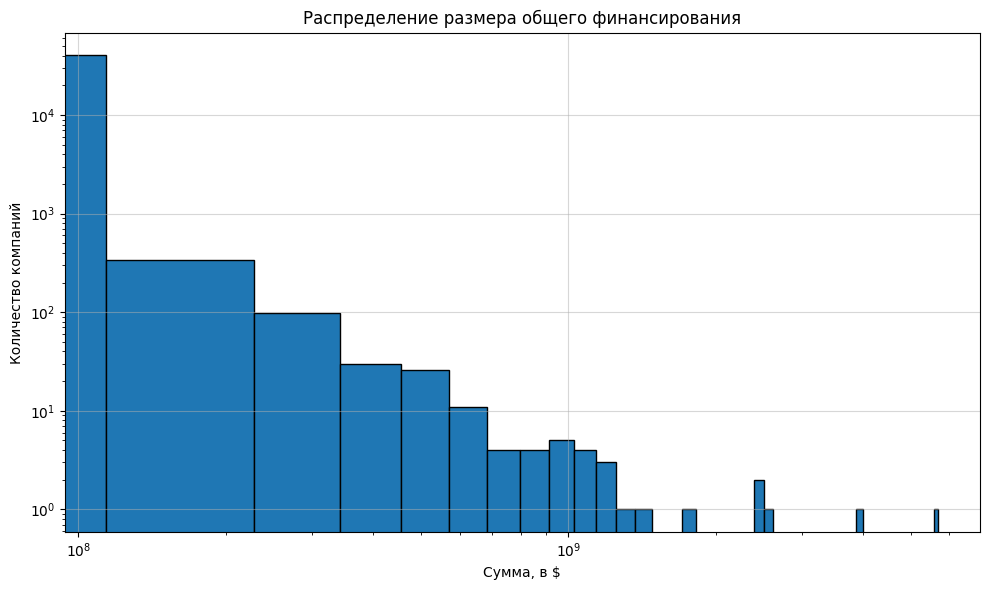

In [62]:
# Построим график распределения размера общего финансирования:
plt.figure(figsize=(10,6))
hist, bin_edges, i = plt.hist(acquired_company['funding_total'], bins=50, edgecolor='k')
plt.grid(True, alpha=0.5)
plt.title('Распределение размера общего финансирования')
plt.xlabel('Сумма, в $')
plt.ylabel('Количество компаний')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

График показывает правое ассиметричное распределение данных.

In [63]:
# Найдем наибольшее количество компаний в одном интервале:
max(hist)

40361.0

In [64]:
# Найдем границу интервала с максимальным количеством компаний:
bin_edges[hist.argmax() + 1]

114000000.0

График и статистические показатели демонстрируют, что большее количество компаний - 40361 шт. имеют финансирование в размере до 114 млн долларов. 1 квартиль равен 0 долларов, соответственно, 25% компаний не получили финансирование. Медиана составляет 600 тыс долларов, когда как среднее значение - более 10 млн долларов. Это указывает на значительный перекос в распределении — большинство компаний привлекло небольшие суммы, и лишь малая часть - суммы более сотни миллионов и даже миллиардов. Максимальная сумма финансирования составила 5 млрд 700 млн долларов.




### 3.3. Куплены забесплатно?

Необходимо исследовать компании, которые были проданы за ноль или за один доллар, и при этом известно, что у них был ненулевой общий объём финансирования.

In [65]:
# Отфильтруем компании, которые были проданы за 0 или за 1 доллар и у которых был ненулевой общий объём финансирования:
low_priced_company = acquired_company[(acquired_company['price_amount']<=1) & (acquired_company['funding_total']>0)]

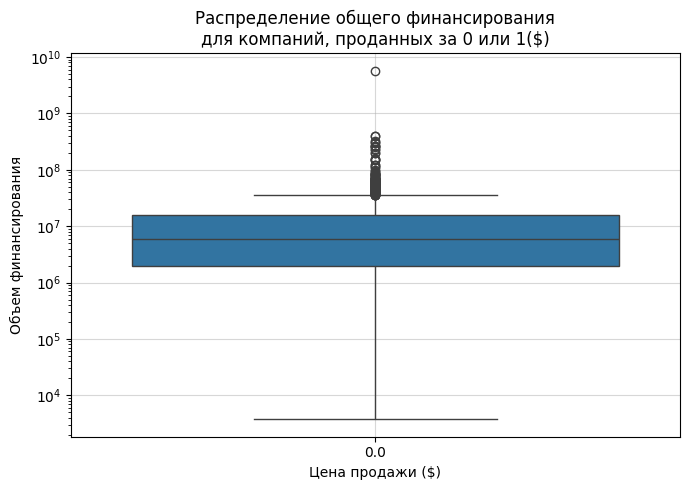

In [66]:
# Построим диаграмму размаха:
plt.figure(figsize=(7, 5))
sns.boxplot(data=low_priced_company, x='price_amount', y='funding_total')
plt.yscale('log')
plt.title('Распределение общего финансирования\nдля компаний, проданных за 0 или 1($)')
plt.xlabel('Цена продажи ($)')
plt.ylabel('Объем финансирования')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [67]:
# Вычислим квартили Q1 и Q3:
Q1 = low_priced_company['funding_total'].quantile(0.25)
Q3 = low_priced_company['funding_total'].quantile(0.75)

# Вычислим межквартильный размах IQR:
IQR = Q3 - Q1

# Определим верхний порог для выбросов:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Первый квартиль: {Q1}')
print(f'Третий квартиль: {Q3}')
print(f'Нижняя граница выбросов: {lower_bound}')
print(f'Верхняя граница выбросов: {upper_bound}')

Первый квартиль: 2000000.0
Третий квартиль: 15500000.0
Нижняя граница выбросов: -18250000.0
Верхняя граница выбросов: 35750000.0


Нижняя граница выбросов равна -18.2 млн долларов, что невозможно, поэтому нижние выбросы можно рассматривать по первому квартилю (2 млн долларов). 

Верхняя граница составляет 35.7 млн долларов. Это значение намного больше 75% процентиля в 15.5 млн долларов, поэтому выбросов, которые выходят за границу верхнего порога, намного меньше по количеству. У таких компаний было необычно много вложений, но они всё равно продались за 0 долларов. Вероятно, стартапы были успешными и имели большие перспективы развития, но возникли некоторые трудности.

In [68]:
# Выведем краткое описание статистики по столбцу funding_total:
low_priced_company['funding_total'].describe()

count    1.618000e+03
mean     1.815296e+07
std      1.445030e+08
min      3.750000e+03
25%      2.000000e+06
50%      6.000000e+06
75%      1.550000e+07
max      5.700000e+09
Name: funding_total, dtype: float64

In [69]:
# Посчитаем процент компаний, купленных забесплатно, от общего числа:
round(low_priced_company.shape[0]/acquired_company.shape[0]*100, 2)

3.96

Всего 1618 компаний, которые были проданы за 0 долларов и у которых был ненулевой общий объём финансирования (ни одна компания не была продана за 1 доллар). Это количество составляет лишь 4% от общего числа рассматриваемых компаний на данном этапе анализа. 

Первый квартиль равен 2 млн долларов, третий - 15 млн 500 тыс долларов. Соответственно, между суммами финансирования компаний большой разброс данных. Также можно отметить, что компания с максимальной суммой финансирования в 5 млрд 700 млн долларов тоже была отдана забесплатно.

Исходя из того, что компании с финансированием были проданы забесплатно, можно выдвинуть следующие гипотезы, почему это могло произойти:
- компания могла обанкротиться или оказаться на грани банкротства.
- у компании могут быть большие долги, обязательства перед инвесторами, судебные иски.
- компания могла быть частью холдинга, и её "продали" дочерней структуре для учета или налоговых целей.

Поэтому никогда нельзя точно сказать, что бизнес добьется успеха, а не выгорит.


### 3.4. Цены стартапов по категориям

Категории стартапов с типично высокими ценами покупки стартапов и значительным разбросом цен могут быть привлекательными для крупных инвесторов, которые готовы к высоким рискам ради потенциально больших доходов. Среди категорий стартапов необходимо выделить категории стартапов, характеризующиеся:

- типично высокими ценами;
- наибольшим разбросом цен за стартап.

In [70]:
# Выведем статистику цены покупки:
acquired_company['price_amount'].describe(percentiles=[0.73, 0.74, 0.99])

count    9.390000e+03
mean     3.939881e+08
std      2.684624e+10
min      0.000000e+00
50%      0.000000e+00
73%      0.000000e+00
74%      1.400000e+03
99%      2.600000e+09
max      2.600000e+12
Name: price_amount, dtype: float64

In [71]:
# Выведем количество нулевых покупок:
(acquired_company['price_amount']==0).sum()

6917

In [72]:
# Посчитаем количество компаний с ценами, за исключением пропусков:
price_amount_without_nan = acquired_company['price_amount'].dropna()
price_amount_without_nan.count()

9390

73% процентиля стоимости компаний равняются нулю. Следовательно, большая часть компаний были проданы забесплатно - 6917 шт из 9390 компаний. Эти данные помешают анализу стоимости покупок стартапов, поэтому исключим стоимость покупки, равную нулю и также избавимся от пропусков.

В статистических данных также можно отметить, что максимальное значение в 1000 раз выше 99 процентиля, что означает огромные выбросы данных.

In [73]:
# Отфильтруем стоимость покупки:
filtered_acquired_company_category = acquired_company[acquired_company['price_amount']>0]

# Выведем количество компаний для дальнейшего анализа:
filtered_acquired_company_category.shape[0]

2473

Среди категорий стартапов найдем среднее значение, чтобы составить топ из типично высоких цен. Используем среднее, потому что таким образом можно учесть выбросы в виде очень высоких значений продаж, которые могут быть вполне реальными.

In [74]:
# Найдем топ категорий по средней цене покупки:
top_mean_price_by_category = filtered_acquired_company_category.groupby('category_code')['price_amount'].mean().sort_values(ascending=False)
top_mean_price_by_category.head(10).reset_index()

,category_code,price_amount
0,enterprise,2.295955e+10
1,automotive,2.547667e+09
2,public_relations,1.820631e+09
3,real_estate,1.465500e+09
4,health,1.065050e+09
5,manufacturing,8.137572e+08
6,biotech,7.359153e+08
7,sports,6.225000e+08
8,finance,6.043975e+08
9,security,6.028958e+08


Составим топ-5 категорий, т.к. у них самые высокие средние суммы сделок. Начиная с категории manufacturing, сумма продажи уже составляет сотни миллионов, а не миллиарды.

Построим для наглядности столбчатую диаграмму.

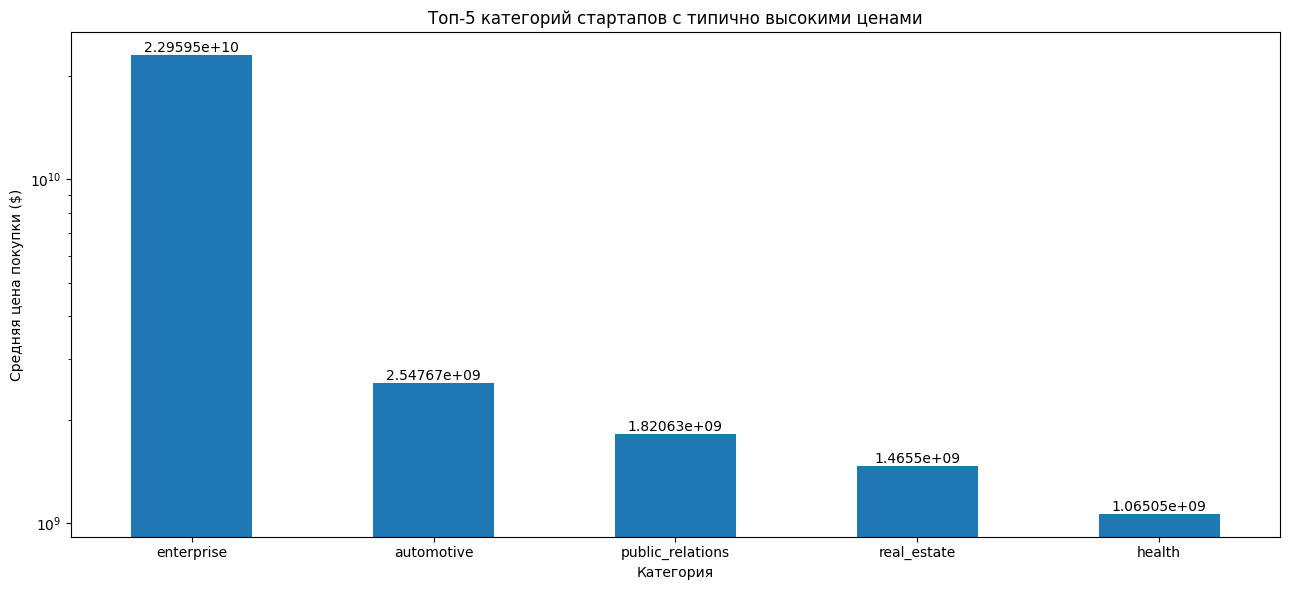

In [75]:
# Выведем топ-5 категорий:
top5_mean_price_by_category = top_mean_price_by_category.head(5)

# Построим график топ-5 категорий по средней цене покупки:
top5_mean_ax = top5_mean_price_by_category.plot(kind='bar',
                                   figsize=(13,6),
                                   rot=0)
plt.yscale('log')
plt.title('Топ-5 категорий стартапов с типично высокими ценами')
plt.xlabel('Категория')
plt.ylabel('Средняя цена покупки ($)')
plt.tight_layout()
top5_mean_ax.bar_label(top5_mean_ax.containers[0])
plt.show()

Среди стартапов были выбраны топ-5 категорий по средней стоимости покупки. Категория enterprise (крупные предприятия) сильно выбивается вперед остальных 4 категорий из топа. Средняя стоимость покупки компаний этой категории составляет почти 23 млрд долларов. Далее идут automotive (автомобильная промышленность) и public_relations (связь с общественностью) - по 2.5 млрд долларов и 1.8 млрд долларов соответственно.

Можно сделать вывод, что более привлекательной категорией для крупных инвесторов являются крупные коммерческие организации, обладающие значительными ресурсами и работающие на масштабных рынках. Гипотетически, крупные компании менее склонны к рискам банкротства, поэтому вполне логично, что большинство финансов вкладывают именно в эту категорию компаний.

In [76]:
# Найдем топ категорий с наибольшим разбросом цен:
top_std_price_by_category = filtered_acquired_company_category.groupby('category_code')['price_amount'].std().sort_values(ascending=False)
top_std_price_by_category.head(10).reset_index()

,category_code,price_amount
0,enterprise,2.413581e+11
1,public_relations,6.854338e+09
2,real_estate,2.676302e+09
3,automotive,2.581669e+09
4,other,2.060861e+09
5,biotech,1.968195e+09
6,health,1.927100e+09
7,games_video,1.463478e+09
8,security,1.378442e+09
9,mobile,1.319472e+09


Построим диаграммы размаха из первых 4 категорий, т.к. у них наибольший разброс цен за стартап. После 4 категории (automotive) разброс цен снижается - на 500 млн долларов. К тому же в предыдущем топе не присутствуют последующие категории - other, biotech, health, соответственно, они менее выгодны для инвесторов, и их анализировать уже не будем.

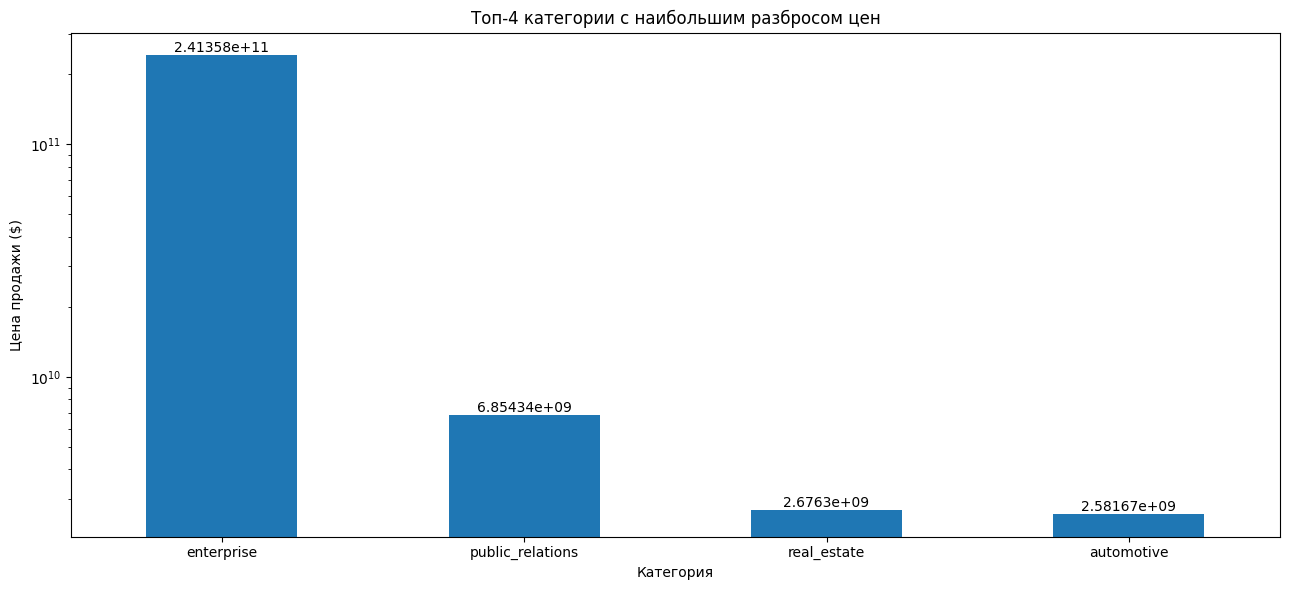

In [77]:
# Выведем топ-4 категорий:
top_std_price_by_category = top_std_price_by_category.head(4)

# Построим график топ-4 категорий c наибольшим разбросом цен:
top4_std_ax = top_std_price_by_category.plot(kind='bar',
                                             figsize=(13,6),
                                             rot=0)

plt.yscale('log')
plt.title('Топ-4 категории с наибольшим разбросом цен')
plt.xlabel('Категория')
plt.ylabel('Цена продажи ($)')
plt.tight_layout()
top4_std_ax.bar_label(top4_std_ax.containers[0])
plt.show()

На этой диаграмме можно отметить, что категория enterprise опять занимает 1 место в топе (разброс цен составляет 241 млрд долларов). Получается, что компании из категории enterprise в среднем продаются за более высокую цену, но распределение цен покупки компаний имеет значительный разброс. Следовательно, компанию могут купить за более низкую цену, совсем далекую от среднего значения цены продажи.

Рассмотрим диаграмму размаха этих 4х категорий.

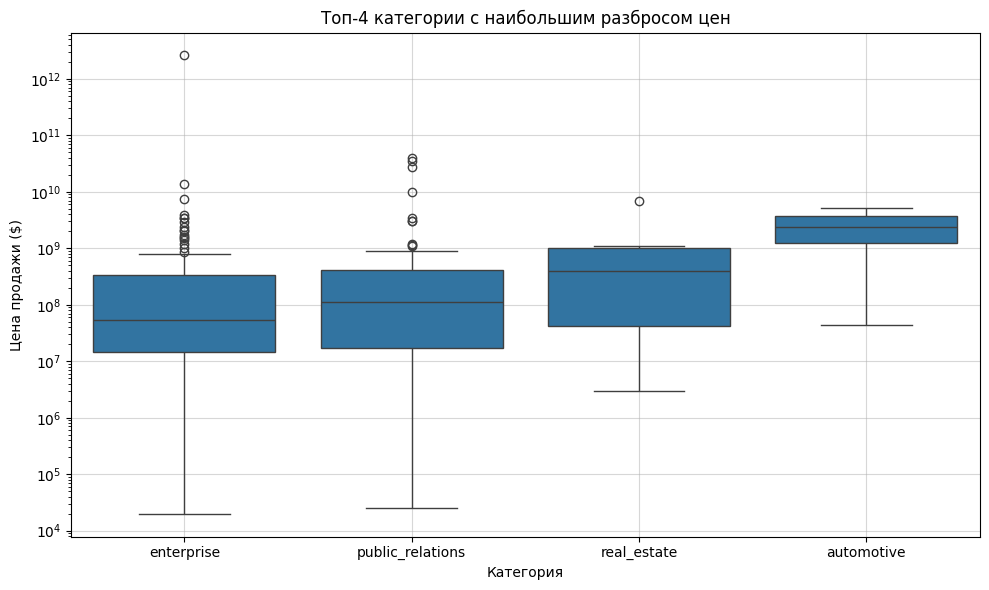

In [78]:
# Отфильтруем данные по топ-4 категориям:
top4_categories = top_std_price_by_category.index
filtered_top4_categories = filtered_acquired_company_category[filtered_acquired_company_category['category_code'].isin(top4_categories)]

# Отсортируем категории:
ordered_categories = ['enterprise', 'public_relations', 'real_estate', 'automotive']

# Построим диаграмму размаха:
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_top4_categories, x='category_code', y='price_amount', order=ordered_categories)
plt.yscale('log')
plt.title('Топ-4 категории с наибольшим разбросом цен')
plt.xlabel('Категория')
plt.ylabel('Цена продажи ($)')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [79]:
# Выведем максимальные значения:
filtered_acquired_company_category.groupby('category_code')['price_amount'].max().sort_values(ascending=False).head()

category_code
enterprise          2.600000e+12
public_relations    3.900000e+10
biotech             2.000000e+10
other               1.840000e+10
mobile              1.250000e+10
Name: price_amount, dtype: float64

На диаграмме размаха можно увидеть огромное количество выбросов у категории enterprise, из-за чего средняя цена и получается настолько высокой. К тому же максимальный выброс составляет 2.6 триллиона, что является самой высокой стоимостью компании среди всех категорий. Соответственно, крупные инвесторы сильно рискуют, вкладывая свои инвестиции в компании данной категории.

In [80]:
# Найдем топ категорий с наибольшим разбросом цен:
filtered_acquired_company_category.groupby('category_code')['price_amount'].median().sort_values(ascending=False).head()

category_code
automotive       2.400000e+09
sports           6.225000e+08
nanotech         5.840000e+08
real_estate      4.000000e+08
manufacturing    3.510000e+08
Name: price_amount, dtype: float64

Категория automotive имеет самый низкий размах цен в топе-4 - около 2.6 млрд долларов. К тому же находится на 2 месте среди самых высоких средних цен по продаже компаний и на 1 месте среди всех категорий по медианной стоимости - 2.4 триллиона долларов. Исходя из этого, можно утверждать, что данная категория является более стабильной на рынке и представляет собой наименьший риск для инвестиций.


### 3.5. Сколько раундов продержится стартап перед покупкой

Заказчика интересует типичное значение количества раундов для каждого возможного статуса стартапа. Для этого необходимо проанализировать значения столбца `funding_rounds`.

In [81]:
# Сгруппируем статусы по среднему значению раундов:
rounds_mean = acquired_company.groupby('status')['funding_rounds'].mean().sort_values(ascending=False)
rounds_mean

status
ipo          1.934375
operating    1.522658
closed       1.381453
acquired     0.525532
Name: funding_rounds, dtype: float64

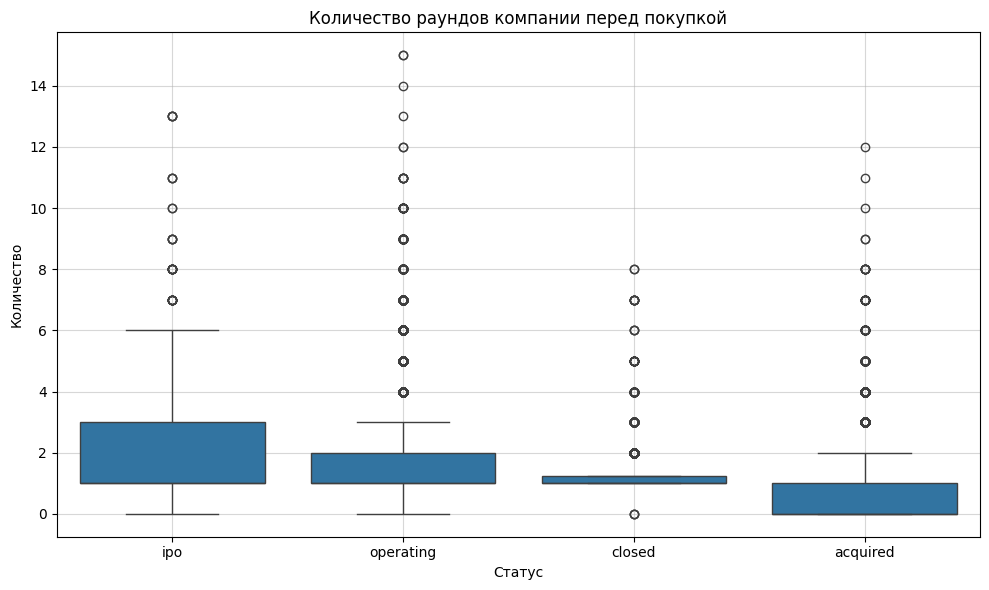

In [82]:
# Отфильтруем данные:
status_of_company = acquired_company[acquired_company['status'].isin(rounds_mean.index)]

# Отсортируем статусы:
ordered_statuses = ['ipo', 'operating', 'closed', 'acquired']

# Построим диаграмму размаха:
plt.figure(figsize=(10, 6))
sns.boxplot(data=status_of_company, x='status', y='funding_rounds', order=ordered_statuses)
plt.title('Количество раундов компании перед покупкой')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Можно отметить, что у закрытых компаний на диаграмме нет усов размаха. Это произошло из-за того, что все значения находятся в пределах межквартильного диапазона IQR.

Большее количество раундов у компаний со статусом IPO (первичное публичное размещение акций) - в среднем почти 2, но также можно отметить выбросы в большую сторону. Из этого следует, что у данных компаний высокая инвестиционная активность. 

Компании со статусом operating (все еще действующие) имеют самый большой разброс значений - до 15 раундов инвестирования. Но в среднем у них все равно 1-2 раунда. 

У закрытых (closed) компаний среднее значение раундов - 1. Большинство стартапов закрываются после 1-2 раундов. 

Acquired (купленные) компании имеют чаще всего 0 или 1 раунд, что говорит о раннем выкупе без долгого привлечения инвестиций. Вероятно, как было выше предположено, данные компании могут выставлять для продажи забесплатно дочерним компаниям.

---

### Промежуточный вывод

В ходе анализа были объединены таблицы с данными о компаниях и сделках по их покупке. В результате был получен датафрейм из 40890 компаний, которые либо сменили владельца, либо потенциально могут быть проданы. Однако качество данных оказалось довольно низким: в большинстве ключевых столбцов наблюдаются значительные пропуски.

Наиболее критичные пропуски:
- 95% пропусков находятся в столбцах о методе оплаты и дате закрытия компании.
- 77% сделок не содержат информации о дате и сумме покупки.
- в 77% данных отсутствуют названия компаний, которые приобрели другие.
- 22% пропусков находятся в столбце с предварительной денежной оценкой компании, который может частично компенсировать отсутствие данных в price_amount.

Анализ суммы сделок показал:
- в выборке много выбросов — медиана (600 тыс долларов) почти в 17 раз меньше среднего значения суммы финансирования (10 млн долларов).
- 25% компаний не получили никакого финансирования.
- большинство компаний привлекло небольшие суммы, и лишь малая часть - суммы более сотни миллионов и миллиардов.

Анализ компаний, которые были проданы за 0 или 1 доллар, с ненулевым объёмом финансирования:
- 4% компаний были проданы за 0 долларов.
- компания с максимальной суммой финансирования в 5 млрд 700 млн долларов была отдана забесплатно, вероятно, из-за банкротства, долгов или внутреннего преобразования.

Цены стартапов по категориям:
- был составлены топ-5 категорий стартапов по средней цене покупки и топ-4 категории с наибольшим разбросом цен за стартап.
- категория enterprise показывает самую высокую среднюю стоимость покупки (почти 23 млрд долларов), однако она также сопровождается значительным разбросом цен.
- аutomotive выделяется высокой стабильностью — меньший разброс, но высокая медианная цена (до 2.4 трлн долларов).

Раунды инвестирования компаний:
- компании со статусом IPO имеют больше всего раундов — в среднем почти 2, что говорит о высоком интересе со стороны инвесторов.
- аcquired-компании чаще всего выкупаются на раннем этапе, иногда — без привлечения финансирования.

---
## Итоговый вывод и рекомендации



В рамках проекта была проведена исследовательская работа с целью анализа стартапов для построения бизнес-модели финансовой компании. 

На этапе первичной предобработки были стандартизированы названия столбцов, изменены типы данных и проанализированы пропуски.

Предварительное исследование показало:
- инвестирование в стартапы усиливается с годами, особенно это заметно в 2013 году, а в 2005 году была зафиксирована самая крупная инвестиция - 5.5 млн долларов.
- большинство компаний — это маленькие стартапы с 1–2 сотрудниками, однако эти данные нельзя считать надежными из-за большого количества выбросов и аномальных значений в виде 0 сотрудников.
- данные об образовании сотрудников имеют множество пропусков и дубликатов — более 59%, поэтому анализ этой информации может исказить результаты.
- информация о сделках по покупке компаний также неполная: отсутствуют суммы, даты, названия покупающих компаний, что снижает уверенность в постановке точных выводов.
- анализ стоимости сделок выявил значительное количество выбросов, из-за чего велик размах суммы покупки. Большинство компаний получило ограниченное финансирование, тогда как лишь немногие привлекли суммы свыше сотен миллионов или миллиардов долларов.
- среди данных были обнаружены 4% компаний, проданные забесплатно, что может говорить о банкротствах или неявных внутренних сделках.
- категории стартапов различаются по уровню и стабильности цен: компании категории enterprise имеют высокую среднюю цену (почти 23 млрд долларов) и большой разброс, automotive — меньший разброс и высокую медиану (до 2.4 трлн долларов).
- статус компании влияет на динамику инвестирования: IPO-компании проходят больше раундов, а выкупленные (acquired) стартапы часто приобретаются быстро, иногда без инвестиций.

Выводы в целом дополняют друг друга и подтверждают общую картину:
- рост интереса к стартапам.
- сложность анализа стартапов по ограниченным данным.
- важность раннего этапа развития компаний для инвесторов.

Однако неполнота данных и наличие выбросов заставляют сомневаться в достоверности анализа.

**Рекомендации:**
- уточнить и дополнить данные — особенно по численности сотрудников, образованию и сделкам по приобретению стартапов. Это поможет повысить точность разработки модели бизнеса.
- сосредоточиться на стартапах на ранних этапах развития, т.к. именно в этот период инвестиции оказывают наибольшее влияние и позволяют лучше прогнозировать будущее компании, особенно с учётом их последующего выхода на IPO или успешной продажи.
- выбирать компании с категорией automotive, которые имеют более стабильную стоимость продажи и меньший риск для инвестиций.